
# 🧠 Titanic — Modeling (Predicting Survival)

**Goal:** build a **reproducible** machine‑learning pipeline to predict `Survived` for the Kaggle Titanic challenge.  
This notebook turns EDA insights into features, evaluates multiple models with proper validation, tunes hyperparameters, and produces a submission file.



## 0) Setup & rationale

**Why a pipeline?** To avoid data leakage and to guarantee that train/validation/test all receive identical preprocessing.  
**What we’ll do:**
1. **Engineer features** motivated by EDA (`Title`, `FamilySize`, `IsAlone`, `Deck`, `log(Fare)`).  
2. **Preprocess** with scikit‑learn `ColumnTransformer` (impute + one‑hot).  
3. **Validate** with **Stratified K‑Fold**, report **accuracy** (Kaggle metric) and holdout **confusion matrix**.  
4. Try multiple models (Logistic Regression, Random Forest, Gradient Boosting, **HistGB**, **XGBoost**).  
5. **Tune hyperparameters** (RandomizedSearchCV) for boosted models.  
6. **Early stopping** with XGBoost (done outside the pipeline for maximum compatibility).  
7. Train on all data and create `submission.csv`.


In [1]:

# Core
import os
import numpy as np
import pandas as pd

# Modeling & pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

# Utils
import matplotlib.pyplot as plt
from scipy.stats import loguniform, randint

np.random.seed(42)



## 1) Load data

We keep the raw DataFrames untouched. All transformations happen inside the pipeline.


In [3]:

DATA_DIR = "../data"
train = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
test  = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
print("train:", train.shape, " test:", test.shape)
train.head(3)

train: (891, 12)  test: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S



## 2) Feature engineering (from EDA)

We create:  
- **Title** from `Name` → collapse to {Mr, Mrs, Miss, Master, Other}  
- **FamilySize** = `SibSp + Parch + 1`  
- **IsAlone** = 1 if `FamilySize == 1` else 0  
- **Deck** from first letter of `Cabin`, `'U'` for unknown  
- **Fare_log1p** = `log1p(Fare)` to reduce skew

**Missing values strategy (inside preprocessing):**  
- `Embarked` → most frequent; `Age`, `Fare` → median; `Deck` keeps `'U'` as a category.



### 2.1) Implementation (wrapped for the pipeline)

Using a `FunctionTransformer` keeps feature creation inside the pipeline and guarantees identical train/valid/test logic.  
We explicitly keep the **pandas DataFrame output** to preserve column names.


In [4]:

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Title from Name
    title = out['Name'].str.extract(r',\s*([^.]+)\.', expand=False).str.strip()
    common = {'Mr','Mrs','Miss','Master'}
    out['Title'] = title.where(title.isin(common), 'Other')

    # Family features
    out['FamilySize'] = out['SibSp'].fillna(0) + out['Parch'].fillna(0) + 1
    out['IsAlone'] = (out['FamilySize'] == 1).astype(int)

    # Deck from Cabin (first letter); NaN -> 'U'
    deck = out['Cabin'].astype(str).str[0]
    deck = deck.where(deck != 'n', 'U')  # 'nan' -> 'U'
    out['Deck'] = deck

    # log1p Fare (safe for zeros/NaN; imputed later)
    out['Fare_log1p'] = np.log1p(out['Fare'])

    return out

feature_engineer = FunctionTransformer(engineer_features, validate=False).set_output(transform="pandas")

TARGET = 'Survived'
ID_COL = 'PassengerId'
X = train.drop(columns=[TARGET])
y = train[TARGET]
X_test_raw = test.copy()

# These are the columns that ColumnTransformer will use after feature engineering
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize','Fare_log1p','Pclass']
categorical_features = ['Sex','Embarked','Title','IsAlone','Deck']



## 3) Preprocessing with `ColumnTransformer`

- **Numeric** → median imputation  
- **Categorical** → most‑frequent imputation + one‑hot encoding (ignore unseen categories)


In [5]:

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
], remainder='drop')



### 3.1) Debug: inspect the transformed design matrix


In [6]:

# Apply feature engineering first
X_eng = feature_engineer.fit_transform(X)

# Fit preprocessing on engineered features
preprocess.fit(X_eng)

# Transform a sample
X_transformed = preprocess.transform(X_eng)
print("Transformed shape:", X_transformed.shape)

# Show first 3 rows for a quick glance
print(X_transformed[:3])

# Feature names (numeric + one-hot categorical)
num_names = numeric_features
cat_names = preprocess.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features).tolist()
feature_names = num_names + cat_names
print("Number of features:", len(feature_names))
print("First 20 feature names:", feature_names[:20])


Transformed shape: (891, 28)
[[22.          1.          0.          7.25        2.          2.1102132
   3.          0.          1.          0.          0.          1.
   0.          0.          1.          0.          0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.        ]
 [38.          1.          0.         71.2833      2.          4.28059312
   1.          1.          0.          1.          0.          0.
   0.          0.          0.          1.          0.          1.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.        ]
 [26.          0.          0.          7.925       1.          2.18885633
   3.          1.          0.          0.          0.          1.
   0.          1.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          1.        ]]
Nu


## 4) Model pipelines

We keep identical preprocessing for all models and swap only the estimator.


In [7]:

pipe_lr = Pipeline([
    ("features", feature_engineer),
    ("preprocess", preprocess),
    ("model", LogisticRegression(max_iter=1000))
])

pipe_rf = Pipeline([
    ("features", feature_engineer),
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(n_estimators=400, max_depth=None, min_samples_leaf=2, n_jobs=-1, random_state=42))
])

pipe_gb = Pipeline([
    ("features", feature_engineer),
    ("preprocess", preprocess),
    ("model", GradientBoostingClassifier(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42))
])

pipe_hgb = Pipeline([
    ("features", feature_engineer),
    ("preprocess", preprocess),
    ("model", HistGradientBoostingClassifier(learning_rate=0.05, max_depth=None, max_bins=255,
                                             early_stopping=True, validation_fraction=0.1, random_state=42))
])

pipe_xgb = Pipeline([
    ("features", feature_engineer),
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="binary:logistic",
        tree_method="hist",
        random_state=42,
        n_jobs=-1
    ))
])

pipelines = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "GradientBoosting": pipe_gb,
    "HistGB": pipe_hgb,
    "XGBoost": pipe_xgb
}
list(pipelines.keys())

['LogisticRegression', 'RandomForest', 'GradientBoosting', 'HistGB', 'XGBoost']


## 5) Validation protocol

We use **StratifiedKFold (5 folds)** and report **mean ± std accuracy** (Kaggle metric).


In [8]:

def cv_score_report(name, pipeline, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, y, cv=skf, scoring="accuracy")
    print(f"{name}: CV accuracy = {scores.mean():.4f} ± {scores.std():.4f}")
    return scores

cv_results = {}
for name, pipe in pipelines.items():
    cv_results[name] = cv_score_report(name, pipe, X, y)


LogisticRegression: CV accuracy = 0.8227 ± 0.0138
RandomForest: CV accuracy = 0.8361 ± 0.0069
GradientBoosting: CV accuracy = 0.8372 ± 0.0240
HistGB: CV accuracy = 0.8361 ± 0.0137
XGBoost: CV accuracy = 0.8350 ± 0.0264



### 5.1) Holdout set & confusion matrix


Holdout accuracy with GradientBoosting: 0.8101


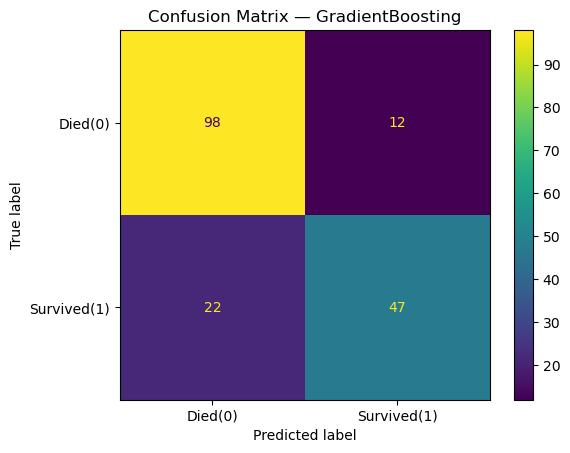

In [9]:

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_name = max(cv_results, key=lambda k: cv_results[k].mean())
best_pipe = pipelines[best_name]
best_pipe.fit(X_train, y_train)
val_preds = best_pipe.predict(X_val)
acc = accuracy_score(y_val, val_preds)
print(f"Holdout accuracy with {best_name}: {acc:.4f}")

cm = confusion_matrix(y_val, val_preds, labels=[0,1])
disp = ConfusionMatrixDisplay(cm, display_labels=['Died(0)','Survived(1)'])
disp.plot()
plt.title(f"Confusion Matrix — {best_name}")
plt.show()



## 6) Hyperparameter tuning (RandomizedSearchCV)

We run a quick random search on **XGBoost** (good tabular baseline).  
Use small `n_iter` if your machine is slow; increase for better results.


In [10]:

xgb_param_dist = {
    "model__n_estimators": randint(200, 800),
    "model__learning_rate": loguniform(1e-3, 3e-1),
    "model__max_depth": randint(3, 7),
    "model__subsample": loguniform(0.5, 1.0),
    "model__colsample_bytree": loguniform(0.5, 1.0),
    "model__reg_lambda": loguniform(1e-2, 10),
    "model__min_child_weight": randint(1, 10)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
xgb_search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=xgb_param_dist,
    n_iter=30,               # adjust up if you want a deeper search
    scoring="accuracy",
    cv=skf,
    refit=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

xgb_search.fit(X, y)
print("Best XGB CV accuracy:", xgb_search.best_score_)
print("Best XGB params:", xgb_search.best_params_)
best_xgb_pipeline = xgb_search.best_estimator_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best XGB CV accuracy: 0.8484401481388488
Best XGB params: {'model__colsample_bytree': np.float64(0.6264118118690402), 'model__learning_rate': np.float64(0.06416866024982448), 'model__max_depth': 6, 'model__min_child_weight': 6, 'model__n_estimators': 746, 'model__reg_lambda': np.float64(0.26100256506134767), 'model__subsample': np.float64(0.5432146321370214)}


## 7) Optional early stopping for XGBoost (native API)

Some XGBoost versions don't accept `early_stopping_rounds` in the sklearn wrapper.  
To be version-proof, I switch to the native API (`xgboost.train`) using `DMatrix`.  
I reuse the same feature engineering + preprocessing, then train with an eval set and early stopping.


In [11]:
import xgboost as xgb  # native API

# Stratified split for early stopping
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

# 1) Engineer + preprocess (same logic as pipeline)
X_tr_eng = feature_engineer.fit_transform(X_tr)
X_va_eng = feature_engineer.transform(X_va)

preprocess.fit(X_tr_eng)
X_tr_prep = preprocess.transform(X_tr_eng)
X_va_prep = preprocess.transform(X_va_eng)

# 2) Build feature names (numeric + one-hot categorical)
ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
num_names = numeric_features
cat_names = ohe.get_feature_names_out(categorical_features).tolist()
feature_names = num_names + cat_names

# 3) Create DMatrices with names (so importances map to real features)
dtrain = xgb.DMatrix(X_tr_prep, label=y_tr, feature_names=feature_names)
dvalid = xgb.DMatrix(X_va_prep, label=y_va, feature_names=feature_names)

# 4) Params: use tuned values if available; else reasonable defaults
best_params = globals().get("xgb_search", None)
if best_params is not None and hasattr(xgb_search, "best_params_"):
    bp = xgb_search.best_params_
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "eta": float(bp["model__learning_rate"]),
        "max_depth": int(bp["model__max_depth"]),
        "subsample": float(bp["model__subsample"]),
        "colsample_bytree": float(bp["model__colsample_bytree"]),
        "lambda": float(bp["model__reg_lambda"]),
        "min_child_weight": int(bp.get("model__min_child_weight", 1)),
    }
    num_round = int(bp["model__n_estimators"])
else:
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "eta": 0.05,
        "max_depth": 4,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "lambda": 1.0,
        "min_child_weight": 1,
    }
    num_round = 400

# 5) Train with early stopping
watchlist = [(dtrain, "train"), (dvalid, "valid")]
xgb_booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=False,
)

# 6) Evaluate on validation set
try:
    # new API
    best_iter = xgb_booster.best_iteration
    va_prob = xgb_booster.predict(dvalid, iteration_range=(0, best_iter + 1))
except Exception:
    # older API
    best_iter = xgb_booster.best_ntree_limit - 1
    va_prob = xgb_booster.predict(dvalid, ntree_limit=xgb_booster.best_ntree_limit)

va_pred = (va_prob >= 0.5).astype(int)
print(f"Early-stopped XGB holdout accuracy: {accuracy_score(y_va, va_pred):.4f}")
print("Best boosting rounds:", best_iter + 1)

# Persist for later steps
XGB_EARLY_PARAMS = params
XGB_EARLY_BEST_ROUNDS = int(best_iter + 1)
XGB_FEATURE_NAMES = feature_names
XGB_PREPROCESS = preprocess  # fitted preprocess
XGB_FE_ENGINEER = feature_engineer  # fitted feature engineer
XGB_BOOSTER = xgb_booster


Early-stopped XGB holdout accuracy: 0.8209
Best boosting rounds: 76


## 8) Train on full data & create submissions

I export two submissions:
1) **Pipeline best-by-CV** (consistent with validation protocol).
2) **XGBoost early-stopped** retrained on all data with `best_rounds`.


In [12]:
os.makedirs("outputs", exist_ok=True)

# 8.1 Pipeline submission (best-by-CV)
final_name = max(cv_results, key=lambda k: cv_results[k].mean())
final_pipe = pipelines[final_name]
final_pipe.fit(X, y)
pipe_pred = final_pipe.predict(X_test_raw).astype(int)
sub_pipe = pd.DataFrame({"PassengerId": X_test_raw["PassengerId"], "Survived": pipe_pred})
sub_pipe_path = os.path.join("../outputs", "submission_pipeline.csv")
sub_pipe.to_csv(sub_pipe_path, index=False)
print("Saved pipeline submission to:", sub_pipe_path)

# 8.2 Early-stopped XGB retrain on ALL data with best rounds
# Re-engineer + preprocess on ALL training data
X_all_eng = XGB_FE_ENGINEER.fit_transform(X)
XGB_PREPROCESS.fit(X_all_eng)
X_all_prep = XGB_PREPROCESS.transform(X_all_eng)

# Prepare test the same way
X_test_eng = XGB_FE_ENGINEER.transform(X_test_raw)
X_test_prep = XGB_PREPROCESS.transform(X_test_eng)

# DMatrices with feature names
dall = xgb.DMatrix(X_all_prep, label=y, feature_names=XGB_FEATURE_NAMES)
dtest = xgb.DMatrix(X_test_prep, feature_names=XGB_FEATURE_NAMES)

# Retrain booster on ALL data with best number of rounds
xgb_final = xgb.train(
    params=XGB_EARLY_PARAMS,
    dtrain=dall,
    num_boost_round=XGB_EARLY_BEST_ROUNDS,
    verbose_eval=False,
)

# Predict test and save
test_prob = xgb_final.predict(dtest)
test_pred = (test_prob >= 0.5).astype(int)
sub_es = pd.DataFrame({"PassengerId": X_test_raw["PassengerId"], "Survived": test_pred})
sub_es_path = os.path.join("../outputs", "submission_xgb_es.csv")
sub_es.to_csv(sub_es_path, index=False)
print("Saved early-stopped XGB submission to:", sub_es_path)


Saved pipeline submission to: ../outputs/submission_pipeline.csv
Saved early-stopped XGB submission to: ../outputs/submission_xgb_es.csv


## 9) Quick model interpretation

I show feature importances for:
- the **pipeline’s final estimator** (if tree-based), and
- the **XGBoost booster** trained with early stopping (gain-based importances).

In [13]:
# 9.1 Pipeline model importances (tree-based only)
def get_feature_names(preprocessor, numeric_feats, categorical_feats):
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    return numeric_feats + ohe.get_feature_names_out(categorical_feats).tolist()

if hasattr(final_pipe.named_steps['model'], "feature_importances_"):
    X_eng_all = feature_engineer.transform(X)
    final_pipe.named_steps['preprocess'].fit(X_eng_all)
    feat_names_pipe = get_feature_names(final_pipe.named_steps['preprocess'], numeric_features, categorical_features)
    importances = final_pipe.named_steps['model'].feature_importances_
    pd.Series(importances, index=feat_names_pipe).sort_values(ascending=False).head(20)
else:
    print("Pipeline final model is not tree-based (no feature_importances_).")

# 9.2 XGB booster importances (gain)
xgb_gain = XGB_BOOSTER.get_score(importance_type="gain")
imp_series = pd.Series(xgb_gain).sort_values(ascending=False).head(20)
imp_series

Title_Mr      17.099874
Sex_female    15.740839
Sex_male      10.565970
Title_Miss    10.045524
Title_Mrs      5.730789
Pclass         4.691372
Deck_U         4.663159
FamilySize     3.645081
Embarked_C     2.850959
Embarked_S     2.517258
Fare_log1p     2.171926
Fare           2.167045
SibSp          2.012918
IsAlone_0      1.982650
Age            1.720424
Parch          1.284808
dtype: float64

## 10) Conclusions & next steps

- Kept a leakage-safe pipeline aligned with EDA; validated with Stratified K-Fold.
- Added boosted models and tuned XGBoost with a random search.
- Implemented version-proof early stopping using the **native xgboost API**.
- Exported two submissions: best pipeline and early-stopped XGB.

**Next:** Try a few extra engineered features (`FarePerPerson`, `IsChild`, `TicketGroupSize`), expand tuning for XGBoost/LightGBM, and explore a simple soft-voting ensemble.